# Biblioteki

In [1]:
import os
import mne
import numpy as np
from scipy.signal import butter, filtfilt
from scipy import signal, misc
import matplotlib.pyplot as plt

# Ładowanie danych z pliku

In [2]:
PATH_KONTROLA = "C:/Users/kuba_/Desktop/Studia/semestr7/eeg/project/kontrola/"

if(os.path.exists(PATH_KONTROLA)):
    file_names = os.listdir(PATH_KONTROLA)
    kontrola_bdf_paths = [PATH_KONTROLA + str(file_name) for file_name in file_names]
    
print("Katalog kontroli zawiera ", len(kontrola_bdf_paths), " plików")

Katalog kontroli zawiera  18  plików


In [3]:
raw_files = []

for path in kontrola_bdf_paths:
    raw = mne.io.read_raw_bdf(path)
    raw_files.append(raw)

Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\kontrola\cfp04.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\kontrola\cfp06.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\kontrola\cfp07.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\kontrola\cfp08.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\semestr7\eeg\project\kontrola\cfp09.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Extracting EDF parameters from C:\Users\kuba_\Desktop\Studia\seme

###### Wczytanie eventow i czestotliwosci probkowania.

In [4]:
events_all = []
sampling_freq_all = []

for count, raw in enumerate(raw_files):
    sampling_freq_all.append(raw.info['sfreq'])
    events_all.append(mne.find_events(raw, stim_channel='Status', initial_event=True))
    events_all[count][:, 0] = events_all[count][:, 0] * sampling_freq_all[count] 

292 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
301 events found
Event IDs: [   68    72    80   132   136   144   252 65536 65790]
313 events found
Event IDs: [    1     3    68    72    80   132   136   144   252   255 65536 65791]
292 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
293 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
290 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
293 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
293 events found
Event IDs: [   68    72    80   132   136   144   252 65536 65791]
293 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
293 events found
Event IDs: [   68    72    80   132   136   144   252 65536]
293 events found
Event IDs: [   68    72    80   132   136   144   252 65536 65791]
292 events found
Event IDs: [   68    72    80   132   136   144 65536]
292 events found
Event IDs: 

# Cięcie sygnału zgodnie z triggerami

In [5]:
# triggers = [start, stop]
left_triggers = [144, 80]
right_triggers = [136, 72]
rest_triggers = [132, 68]

# slownik dla warunków zawierająca wszystkie triggery uporzadkowane w stosownej kolejnosci w listach
samples_all = {'left': [],
               'rest': []}

for count, raw in enumerate(raw_files):
    left_samples = np.zeros((1,2))
    right_samples = np.zeros((1,2))
    rest_samples = np.zeros((1,2))
    
    # sprawdzenie czy  wartosc 3 kolumny (kod triggera) jest rowny iterowanemu triggerowi
    # sprawdzenie czy wartosc z 1 kolumny eventow nie zostala juz przypisana do tablicy samples
    for e in range(len(events_all[count])):
        if events_all[count][e][2] == left_triggers[1]:
            if events_all[count][e][0] not in left_samples:
                # uzycie jedynie trigger stopu i stworzenie odcinka czasu od sekundy wczesniej do 4 sek po nim
                # oszczednosc obliczen
                left_samples[-1][0] = events_all[count][e][0] - 1000000
                left_samples[-1][1] = events_all[count][e][0] + 4000000
                left_samples = np.vstack([left_samples, [0,0]])
                
        if events_all[count][e][2] == rest_triggers[1]:
            if events_all[count][e][0] not in rest_samples:
                rest_samples[-1][0] = events_all[count][e][0] - 1000000
                rest_samples[-1][1] = events_all[count][e][0] + 4000000
                rest_samples = np.vstack([rest_samples, [0,0]])
                
    left_samples = np.delete(left_samples, (-1), axis=0) 
    rest_samples = np.delete(rest_samples, (-1), axis=0) 

    left_samples = (left_samples / sampling_freq_all[count]).astype(int)
    rest_samples = (rest_samples / sampling_freq_all[count]).astype(int) 

    samples_all['left'].append(left_samples)
    samples_all['rest'].append(rest_samples)

    
samples_all['left'] = np.array(samples_all['left'])
samples_all['rest'] = np.array(samples_all['rest'])

In [6]:
print(len(samples_all['left']), "- Ilosc osob w grupie wykonujacych polecenie uniesienia prawej reki")
print(len(samples_all['left'][0]), "- Ilosc powtorzen komendy w calej probie dla pierwszego pacjenta")

18 - Ilosc osob w grupie wykonujacych polecenie uniesienia prawej reki
48 - Ilosc powtorzen komendy w calej probie dla pierwszego pacjenta


### Wygenerowanie wektora czasu i amplitudy z danych z prawej reki i odpoczynku

In [7]:
left_dataset = np.zeros((len(samples_all['left']), len(samples_all['left'][0])), dtype=object)
left_timeset = np.zeros((len(samples_all['left']), len(samples_all['left'][0])), dtype=object)
rest_dataset = np.zeros((len(samples_all['rest']), len(samples_all['rest'][0])), dtype=object)
rest_timeset = np.zeros((len(samples_all['rest']), len(samples_all['rest'][0])), dtype=object)

for count, raw in enumerate(raw_files):  
    for y in range(len(samples_all['left'][count])):
        datay, timey = raw.get_data(start = int(samples_all['left'][count][y][0]), stop = int(samples_all['left'][count][y][1]), return_times=True)
        left_dataset[count][y] = datay
        left_timeset[count][y] = timey
        
    for z in range(len(samples_all['rest'][count])):
        dataz, timez = raw.get_data(start = int(samples_all['rest'][count][z][0]), stop = int(samples_all['rest'][count][z][1]), return_times=True)
        rest_dataset[count][z] = dataz
        rest_timeset[count][z] = timez


# FILTRACJE

In [8]:
def mastoid_filter(data, mastoid_data):
    final_y = np.copy(data)
    y = np.copy(data)
    avg = (mastoid_data[0] + mastoid_data[1]) / 2
    
    for channel in range(len(data)):
        final_y[channel] = y[channel] - avg
        
    return final_y

In [9]:
def small_laplacian_filter(working_data, final_data, times, working_channels):
    averages = np.zeros((len(main_electrodes), len(times)))
    y = np.copy(working_data)
    new_y = np.copy(final_data)
    for channel in range(len(working_channels)):
        if working_channels[channel] in C3_small_laplacian:
            averages[0] = averages[0] + y[channel]
        
        if working_channels[channel] in C4_small_laplacian:
            averages[1] = averages[1] + y[channel]
            
        if working_channels[channel] in Cz_small_laplacian:
            averages[2] = averages[2] + y[channel]
            
    averages = averages/4
    final_y = np.zeros((len(main_electrodes), len(times)))

    for avg in range(len(main_electrodes)):
        if main_channels_order[avg] == main_electrodes[0]:
            final_y[avg] = new_y[avg] - averages[0]
            
        if main_channels_order[avg] == main_electrodes[1]:
            final_y[avg] = new_y[avg] - averages[1]

        if main_channels_order[avg] == main_electrodes[2]:
            final_y[avg] = new_y[avg] - averages[2]
      
    return final_y

In [10]:
def butter_filter(data, low_cutoff, high_cutoff, fs, order, filter_type):
    nyq = 0.5 * fs
    low_normal_cutoff = low_cutoff / nyq
    high_normal_cutoff = high_cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, [low_normal_cutoff, high_normal_cutoff], btype=filter_type, analog=False)
    y = np.copy(data)
    for channel in range(len(y)):
        y[channel] = filtfilt(b, a, np.ravel(y[channel])) 
        
    return y

In [11]:
reference_electrodes = ['EXG1', 'EXG2']
main_electrodes = ['C3', 'C4', 'Cz']

C3_small_laplacian = ['C3', 'FC3', 'C1', 'CP3', 'C5']
C4_small_laplacian = ['C4', 'FC4', 'C6', 'CP4', 'C2']
Cz_small_laplacian = ['Cz', 'FCz', 'C2', 'CPz', 'C1']
other_electrodes = C3_small_laplacian[1:] + C4_small_laplacian[1:] + Cz_small_laplacian[1:]

In [12]:
ch_names_all = []

for count, raw in enumerate(raw_files):
    ch_names = raw.ch_names
    ch_names_all.append(ch_names)

# Stworzenie serii danych tylko dla elektrod potrzebnych do filtracji przestrzennej

In [13]:
# MASTOIDY REST
new_dataset_rest = np.copy(rest_dataset)
mastoidy_dataset_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)

for count in range(len(rest_dataset)):
    for period in range(len(rest_dataset[count])):
        mastoidy_data = np.zeros((len(ch_names_all[count]), len(rest_timeset[count][period])))

        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in reference_electrodes:
                mastoidy_data[i] = new_dataset_rest[count][period][i]
                
        mastoidy_data = mastoidy_data[np.all(mastoidy_data != 0, axis=1)]
        
        mastoidy_dataset_rest[count][period] = mastoidy_data



In [14]:
# MASTOIDY LEFT
new_dataset_left = np.copy(left_dataset)
mastoidy_dataset_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)

for count in range(len(left_dataset)):
    for period in range(len(left_dataset[count])):
        if type(left_timeset[count][period]) == int:
            print(left_timeset[count][period]) 
        mastoidy_data = np.zeros((len(ch_names_all[count]), len(left_timeset[count][period])))

        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in reference_electrodes:
                mastoidy_data[i] = new_dataset_left[count][period][i]
                
        mastoidy_data = mastoidy_data[np.all(mastoidy_data != 0, axis=1)]
        
        mastoidy_dataset_left[count][period] = mastoidy_data


In [15]:
new_dataset_rest = np.copy(rest_dataset)
working_dataset_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)
working_channels_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)
final_dataset_rest = np.zeros((len(rest_dataset), len(rest_dataset[0])), dtype=object)

for count in range(len(rest_dataset)):
    for period in range(len(rest_dataset[count])):
        working_data = np.zeros((len(ch_names_all[count]), len(rest_timeset[count][period])))
        final_data = np.zeros((len(ch_names_all[count]), len(rest_timeset[count][period])))
        working_channels = []
        main_channels_order = []
        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in other_electrodes:
                working_data[i] = new_dataset_rest[count][period][i]
                working_channels.append(ch_names_all[count][i])

            if ch_names_all[count][i] in main_electrodes:
                final_data[i] = new_dataset_rest[count][period][i]
                main_channels_order.append(ch_names_all[count][i])
                
        working_data = working_data[np.all(working_data != 0, axis=1)]
        final_data = final_data[np.all(final_data != 0, axis=1)]
        
        working_dataset_rest[count][period] = working_data
        working_channels_rest[count][period] = working_channels
        final_dataset_rest[count][period] = final_data
        
print("Liczba elektrod = ", len(working_dataset_rest[0][0]))
print(main_channels_order)

Liczba elektrod =  10
['C3', 'Cz', 'C4']


In [16]:
new_dataset_left = np.copy(left_dataset)
working_dataset_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)
working_channels_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)
final_dataset_left = np.zeros((len(left_dataset), len(left_dataset[0])), dtype=object)

for count in range(len(left_dataset)):
    for period in range(len(left_dataset[count])):
        working_data = np.zeros((len(ch_names_all[count]), len(left_timeset[count][period])))
        final_data = np.zeros((len(ch_names_all[count]), len(left_timeset[count][period])))
        working_channels = []
        main_channels_order = []
        for i in range(len(ch_names_all[count])):
            if ch_names_all[count][i] in other_electrodes:
                working_data[i] = new_dataset_left[count][period][i]
                working_channels.append(ch_names_all[count][i])

            if ch_names_all[count][i] in main_electrodes:
                final_data[i] = new_dataset_left[count][period][i]
                main_channels_order.append(ch_names_all[count][i])
                
        working_data = working_data[np.all(working_data != 0, axis=1)]
        final_data = final_data[np.all(final_data != 0, axis=1)]
        
        working_dataset_left[count][period] = working_data
        working_channels_left[count][period] = working_channels
        final_dataset_left[count][period] = final_data
        
print("Liczba elektrod = ", len(working_dataset_left[0][0]))
print(main_channels_order)

Liczba elektrod =  10
['C3', 'Cz', 'C4']


In [17]:
print(len(working_dataset_rest))
print(len(working_dataset_rest[11]))
print(len(working_dataset_rest[0][0])) 
print(len(working_dataset_rest[0][0][0]))

18
48
10
4883


### Filtracja z uzyciem mastoid dla odpoczynku

In [18]:
filtered_signal_rest = np.copy(working_dataset_rest)
filtered_signal_left = np.copy(working_dataset_left)
'''
count - liczba pacjentow
period - liczba odcinkow czasu
'''

for count in range(len(working_dataset_rest)):
    for period in range(len(working_dataset_rest[count])):
            REST_mastoid_filter = mastoid_filter(working_dataset_rest[count][period], mastoidy_dataset_rest[count][period])
            filtered_signal_rest[count][period] = REST_mastoid_filter
            LEFT_mastoid_filter = mastoid_filter(working_dataset_left[count][period], mastoidy_dataset_left[count][period])
            filtered_signal_left[count][period] = LEFT_mastoid_filter
            

### Filtracja przestrzenna odpoczynek

In [19]:
new_filtered_signal_rest = np.copy(filtered_signal_rest)
new_filtered_signal_left = np.copy(filtered_signal_left)

for count in range(len(rest_dataset)):
    for period in range(len(rest_dataset[count])):
        new_filtered_signal_rest[count][period] = small_laplacian_filter(filtered_signal_rest[count][period], final_dataset_rest[count][period], rest_timeset[count][period], working_channels_rest[count][period])
        new_filtered_signal_left[count][period] = small_laplacian_filter(filtered_signal_left[count][period], final_dataset_left[count][period], left_timeset[count][period], working_channels_left[count][period])

### Filtracja czestotliwosciowa

In [20]:
order = 5
low_cutoff = 2
high_cutoff = 42
final_filtered_signal_rest = np.copy(new_filtered_signal_rest)
final_filtered_signal_left = np.copy(new_filtered_signal_left)

for count, raw in enumerate(raw_files):
    sampling_freq = raw.info['sfreq']
    for period in range(len(new_filtered_signal_rest[count])):
        final_filtered_signal_rest[count][period] = butter_filter(new_filtered_signal_rest[count][period], low_cutoff, high_cutoff, sampling_freq, order, 'band')
        final_filtered_signal_left[count][period] = butter_filter(new_filtered_signal_left[count][period], low_cutoff, high_cutoff, sampling_freq, order, 'band')
        
        



C:\Users\kuba_\Anaconda3\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


In [23]:
left_vectors = np.zeros((len(final_filtered_signal_left), len(final_filtered_signal_left[0])), dtype=object)
rest_vectors = np.zeros((len(final_filtered_signal_rest), len(final_filtered_signal_rest[0])), dtype=object)

for patient in range(len(final_filtered_signal_left)):
    sampling_freq = sampling_freq_all[patient]
    for period in range(len(final_filtered_signal_left[patient])):
        L_vector = []
        R_vector = []
        for electrode in range(len(final_filtered_signal_left[patient][period])):
# LEFT ARM
            data_feat_left = final_filtered_signal_left[patient][period][electrode]
            # HJORTH
            dt = 1 / sampling_freq
            
            m0 = np.mean(np.square(data_feat_left))
            m2 = np.mean(np.square(np.diff(data_feat_left) / dt))
            zx = np.diff(data_feat_left) / dt
            m4 = np.mean(np.square(np.diff(zx) / dt))
            
            activity = np.sqrt(m0)
            mobility = np.sqrt(m2/m0)
            complexity = np.sqrt((m4 / m2) - (m2/m0))
            
            # STATS
            average = np.average(data_feat_left)
            coeff_of_variation = (np.std(data_feat_left)) / average
            zero_crossings = len(list(np.where(np.diff(np.sign(data_feat_left)))[0]))
            
            L_vector.extend([activity, mobility, complexity, average, coeff_of_variation, zero_crossings])     
# REST 
            data_feat_rest = final_filtered_signal_rest[patient][period][electrode]
            # HJORTH
            dt = 1 / sampling_freq

            m0 = np.mean(np.square(data_feat_rest))
            m2 = np.mean(np.square(np.diff(data_feat_rest) / dt))
            zx = np.diff(data_feat_rest) / dt
            m4 = np.mean(np.square(np.diff(zx) / dt))

            activity = np.sqrt(m0)
            mobility = np.sqrt(m2/m0)
            complexity = np.sqrt((m4 / m2) - (m2/m0))

            # STATS
            average = np.average(data_feat_rest)
            coeff_of_variation = (np.std(data_feat_rest)) / average
            std = np.std(data_feat_rest)
            zero_crossings = len(list(np.where(np.diff(np.sign(data_feat_rest)))[0]))
            
            R_vector.extend([activity, mobility, complexity, average, coeff_of_variation, zero_crossings])
     
        left_vectors[patient][period] = L_vector
        rest_vectors[patient][period] = R_vector



In [25]:
print("Kolejnosc elektrod w wektorze: ", main_channels_order)
print("Dlugosc pojedynczego wektora: ", len(left_vectors[0][0]))
print("")
print("Przykladowe wartosci cech dla 1 pacjenta, eksperymentu UNIESIENIA LEWEJ REKI, 1 fragmentu i elektrody C3:")
print("Aktywnosc = ", left_vectors[0][0][0])
print("Ruchliwosc = ", left_vectors[0][0][1])
print("Zlozonosc = ", left_vectors[0][0][2])
print("Srednia = ", left_vectors[0][0][3])
print("Wspolczynnik zmiennosci = ", np.abs(left_vectors[0][0][4]))
print("Liczba zerowych elementów = ", left_vectors[0][0][5])
print("")
print("")
print("Przykladowe wartosci cech dla 1 pacjenta, eksperymentu ODPOCZYNKU, 1 fragmentu i elektrody C3:")
print("Aktywnosc = ", rest_vectors[0][0][0])
print("Ruchliwosc = ", rest_vectors[0][0][1])
print("Zlozonosc = ", rest_vectors[0][0][2])
print("Srednia = ", rest_vectors[0][0][3])
print("Wspolczynnik zmiennosci = ", np.abs(rest_vectors[0][0][4]))
print("Liczba zerowych elementów = ", rest_vectors[0][0][5])

Kolejnosc elektrod w wektorze:  ['C3', 'Cz', 'C4']
Dlugosc pojedynczego wektora:  18

Przykladowe wartosci cech dla 1 pacjenta, eksperymentu UNIESIENIA LEWEJ REKI, 1 fragmentu i elektrody C3:
Aktywnosc =  1.2338748228965193e-05
Ruchliwosc =  71.4267177651379
Zlozonosc =  172.41902457202963
Srednia =  -1.1017833234932177e-07
Wspolczynnik zmiennosci =  111.98441689653255
Liczba zerowych elementów =  146


Przykladowe wartosci cech dla 1 pacjenta, eksperymentu ODPOCZYNKU, 1 fragmentu i elektrody C3:
Aktywnosc =  1.0965100261143001e-05
Ruchliwosc =  72.50950480206858
Zlozonosc =  160.77761888083916
Srednia =  -3.530646798510638e-08
Wspolczynnik zmiennosci =  310.5675544794497
Liczba zerowych elementów =  136


In [26]:
# np.save('kontrola-left-vectors', left_vectors)
# np.save('kontrola-rest-vectors', rest_vectors)

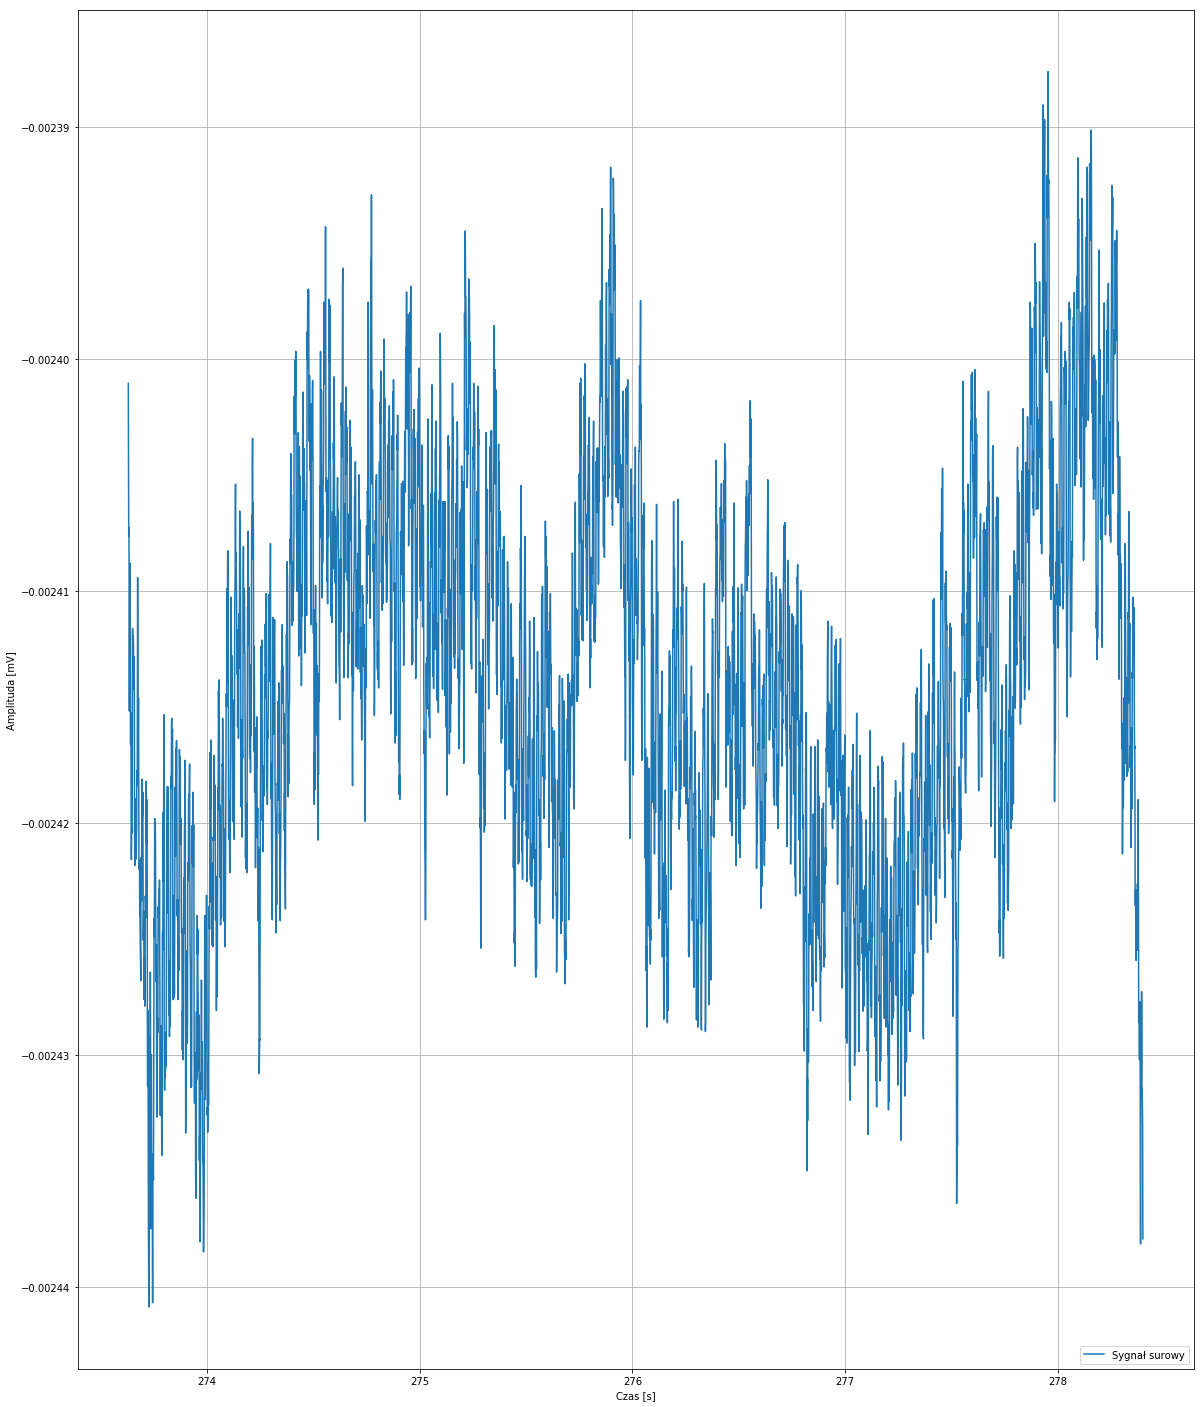

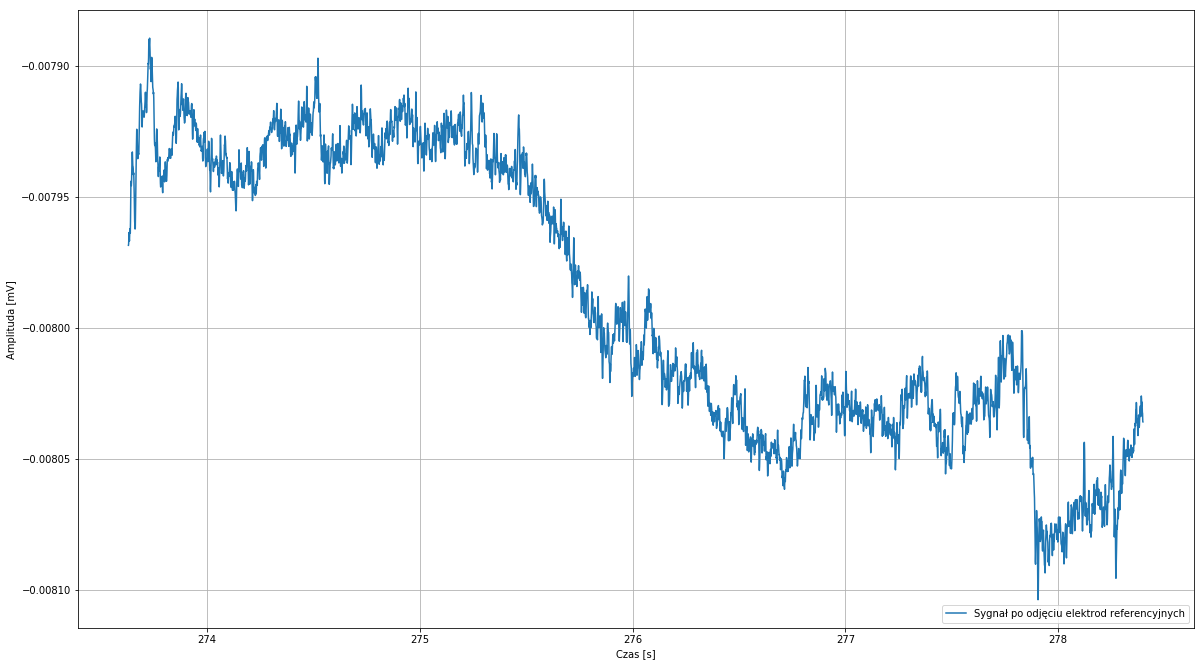

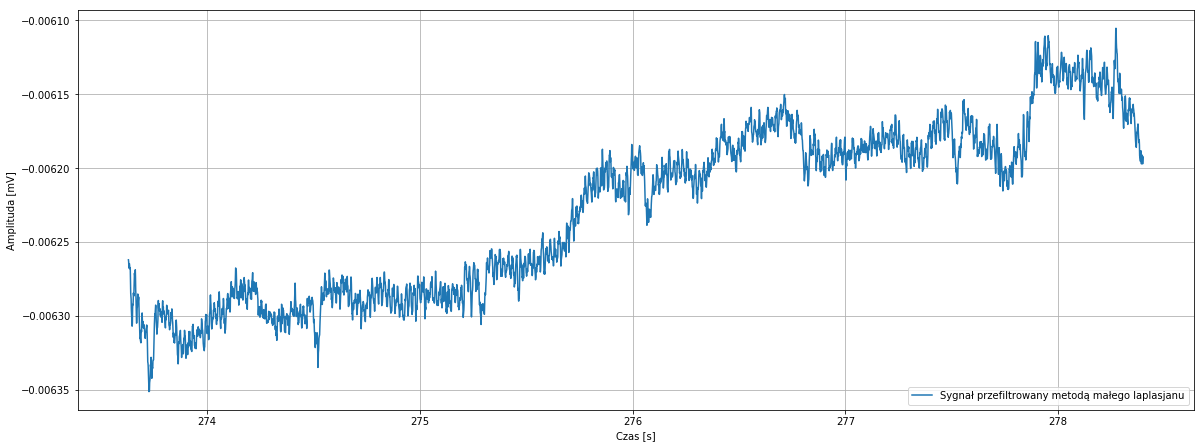

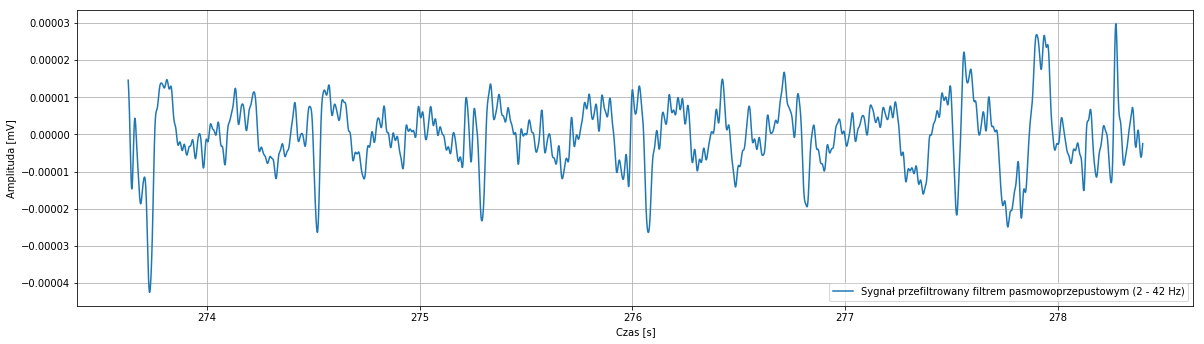

In [27]:
elctr = 49 #elektroda C4
plots = {'Sygnał surowy': left_dataset[10][10][elctr], 
         'Sygnał po odjęciu elektrod referencyjnych': filtered_signal_left[10][10][1],
         'Sygnał przefiltrowany metodą małego laplasjanu': new_filtered_signal_left[10][10][1],
         'Sygnał przefiltrowany filtrem pasmowoprzepustowym (2 - 42 Hz)': final_filtered_signal_left[10][10][1]}


for num, plot in enumerate(plots.keys(), 1):
    plt.rcParams["figure.figsize"] = (20,25)
    plt.subplot(num,1,1)
    plt.plot(left_timeset[10][10], plots[plot], label = plot)
    plt.legend(loc="lower right")
#     plt.title("Elektroda C4 dla komendy uniesienia lewej reki")
    plt.ylabel('Amplituda [mV]')
    plt.xlabel('Czas [s]')
    plt.grid()    
    plt.show()